# Segmentation on CPU

We have lots of pretrained models for different tasks: classification, segmentation, object detection, ...
https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection

In [6]:
import torch
from torchvision.models import segmentation
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
from cpu import utils
import cv2
import numpy as np
import onnx
import onnxruntime as ort

# Pytorch Model

Download the pretrained model and set it to evaluation (no backpropagation or weight update)

In [2]:
model = segmentation.fcn_resnet50(pretrained=True)
model.eval()

/home/blue/miniconda3/envs/cpu_utils/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/blue/miniconda3/envs/cpu_utils/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Let's read an image

In [3]:
input_image = Image.open("road.jpg")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

Let's make inference with it

In [4]:
with torch.no_grad():
    output = model(input_batch)['out'][0]

In [5]:
normalized_masks = torch.nn.functional.softmax(output, dim=1)

In [6]:
normalized_masks.shape

torch.Size([21, 224, 397])

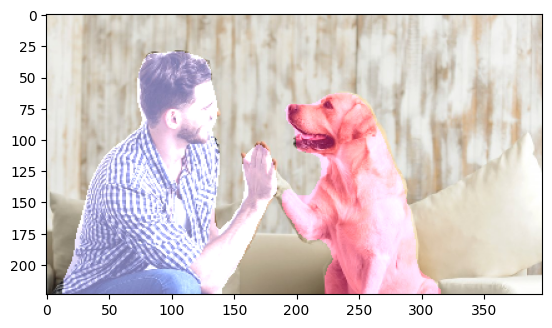

In [7]:
segmented_image = utils.draw_segmentation_map(output)
input_image_resized = cv2.cvtColor(cv2.resize(np.array(input_image), (397, 224)), cv2.COLOR_RGB2BGR)
image_to_plot = utils.image_overlay(input_image_resized, segmented_image)
plt.imshow(image_to_plot)

## Let's convert to ONNX

In [8]:
dummy_input = torch.randn((1, 3, 224, 397))
torch.onnx.export(model, dummy_input, "fcn.onnx", verbose=True, opset_version=16)

Exported graph: graph(%input.1 : Float(1, 3, 224, 397, strides=[266784, 88928, 397, 1], requires_grad=0, device=cpu),
      %classifier.4.weight : Float(21, 512, 1, 1, strides=[512, 1, 1, 1], requires_grad=1, device=cpu),
      %classifier.4.bias : Float(21, strides=[1], requires_grad=1, device=cpu),
      %aux_classifier.4.weight : Float(21, 256, 1, 1, strides=[256, 1, 1, 1], requires_grad=1, device=cpu),
      %aux_classifier.4.bias : Float(21, strides=[1], requires_grad=1, device=cpu),
      %onnx::Conv_548 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cpu),
      %onnx::Conv_549 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_551 : Float(64, 64, 1, 1, strides=[64, 1, 1, 1], requires_grad=0, device=cpu),
      %onnx::Conv_552 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_554 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_555 : Float(64, strides=[1], requires_gra

In [9]:
# Load the ONNX model
onnx_model = onnx.load("fcn.onnx")

# Check that the model is well formed
onnx.checker.check_model(onnx_model)

In [10]:

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch_jit (
  %input.1[FLOAT, 1x3x224x397]
) initializers (
  %classifier.4.weight[FLOAT, 21x512x1x1]
  %classifier.4.bias[FLOAT, 21]
  %aux_classifier.4.weight[FLOAT, 21x256x1x1]
  %aux_classifier.4.bias[FLOAT, 21]
  %onnx::Conv_548[FLOAT, 64x3x7x7]
  %onnx::Conv_549[FLOAT, 64]
  %onnx::Conv_551[FLOAT, 64x64x1x1]
  %onnx::Conv_552[FLOAT, 64]
  %onnx::Conv_554[FLOAT, 64x64x3x3]
  %onnx::Conv_555[FLOAT, 64]
  %onnx::Conv_557[FLOAT, 256x64x1x1]
  %onnx::Conv_558[FLOAT, 256]
  %onnx::Conv_560[FLOAT, 256x64x1x1]
  %onnx::Conv_561[FLOAT, 256]
  %onnx::Conv_563[FLOAT, 64x256x1x1]
  %onnx::Conv_564[FLOAT, 64]
  %onnx::Conv_566[FLOAT, 64x64x3x3]
  %onnx::Conv_567[FLOAT, 64]
  %onnx::Conv_569[FLOAT, 256x64x1x1]
  %onnx::Conv_570[FLOAT, 256]
  %onnx::Conv_572[FLOAT, 64x256x1x1]
  %onnx::Conv_573[FLOAT, 64]
  %onnx::Conv_575[FLOAT, 64x64x3x3]
  %onnx::Conv_576[FLOAT, 64]
  %onnx::Conv_578[FLOAT, 256x64x1x1]
  %onnx::Conv_579[FLOAT, 256]
  %onnx::Conv_581[FLOAT, 128x256x1x1]
  %onnx::Conv_58

In [31]:
ort_session = ort.InferenceSession("fcn.onnx")

outputs = ort_session.run(
    None,
    {"input.1": input_batch.cpu().numpy()},
)


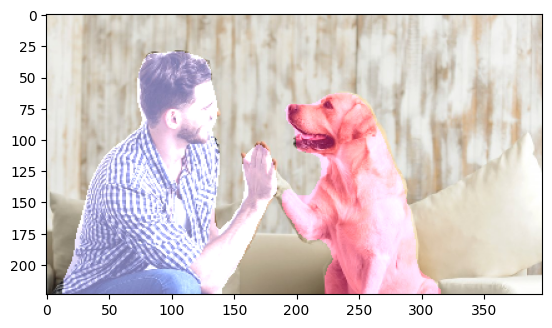

In [33]:
segmented_image = utils.draw_segmentation_map(torch.from_numpy(outputs[0]))
image_to_plot = utils.image_overlay(input_image_resized, segmented_image)
plt.imshow(image_to_plot)

# Let's use OpenVINo

In [34]:
!mo --framework=onnx --input_model "fcn.onnx" --data_type "FP32"


Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/blue/NN-deployment-course/notebooks/cpu/fcn.onnx
	- Path for generated IR: 	/home/blue/NN-deployment-course/notebooks/cpu/.
	- IR output name: 	fcn
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	Fals

In [36]:
!benchmark_app -m fcn.xml -niter 10

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] PerformanceMode was not explicitly specified in command line. Device CPU performance hint will be set to THROUGHPUT.
[ INFO ] OpenVINO:
         API version............. 2022.2.0-7713-af16ea1d79a-releases/2022/2
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.2
         Build................... 2022.2.0-7713-af16ea1d79a-releases/2022/2

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] 

In [37]:
!mo --framework=onnx --input_model "fcn.onnx" --data_type "FP16"

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/blue/NN-deployment-course/notebooks/cpu/fcn.onnx
	- Path for generated IR: 	/home/blue/NN-deployment-course/notebooks/cpu/.
	- IR output name: 	fcn
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	Fals

In [40]:
!benchmark_app -m fcn.xml -niter 10 

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] PerformanceMode was not explicitly specified in command line. Device CPU performance hint will be set to THROUGHPUT.
[ INFO ] OpenVINO:
         API version............. 2022.2.0-7713-af16ea1d79a-releases/2022/2
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.2
         Build................... 2022.2.0-7713-af16ea1d79a-releases/2022/2

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] 

## Let's convert a classification network to int8

In [3]:
import os
from pathlib import Path

from addict import Dict
from openvino.tools.pot.api import DataLoader, Metric
from openvino.tools.pot.engines.ie_engine import IEEngine
from openvino.tools.pot.graph import load_model, save_model
from openvino.tools.pot.graph.model_utils import compress_model_weights
from openvino.tools.pot.pipeline.initializer import create_pipeline
from openvino.runtime import Core
from torchvision import transforms
from torchvision.datasets import CIFAR10
from cpu.utils import CifarDataLoader, Accuracy
import torch

MODEL_DIR = "model_cpu_classification"
os.makedirs(MODEL_DIR, exist_ok=True)
DATA_DIR = "data_cpu_classification"
os.makedirs(DATA_DIR, exist_ok=True)

In [4]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_mobilenetv2_x1_0", pretrained=True)
model.eval()

dummy_input = torch.randn(1, 3, 32, 32)

onnx_model_path = Path(MODEL_DIR) / 'mobilenet_v2.onnx'
ir_model_xml = onnx_model_path.with_suffix('.xml')
ir_model_bin = onnx_model_path.with_suffix('.bin')

torch.onnx.export(model, dummy_input, onnx_model_path, verbose=True)

# Run Model Optimizer to convert ONNX to OpenVINO IR.
!mo --framework=onnx --data_type=FP16 --input_shape=[1,3,32,32] -m $onnx_model_path  --output_dir $MODEL_DIR

Using cache found in /home/blue/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Exported graph: graph(%input.1 : Float(1, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cpu),
      %classifier.1.weight : Float(10, 1280, strides=[1280, 1], requires_grad=1, device=cpu),
      %classifier.1.bias : Float(10, strides=[1], requires_grad=1, device=cpu),
      %onnx::Conv_538 : Float(32, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_539 : Float(32, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_541 : Float(32, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_542 : Float(32, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_544 : Float(16, 32, 1, 1, strides=[32, 1, 1, 1], requires_grad=0, device=cpu),
      %onnx::Conv_545 : Float(16, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_547 : Float(96, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=0, device=cpu),
      %onnx::Conv_548 : Float(96, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_550

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
dataset = CIFAR10(root=DATA_DIR, train=False, transform=transform, download=True)

Files already downloaded and verified


In [6]:
model_config = Dict({
    'model_name': 'mobilenet_v2',
    'model': ir_model_xml,
    'weights': ir_model_bin
})
engine_config = Dict({
    'device': 'CPU',
    'stat_requests_number': 2,
    'eval_requests_number': 2
})
dataset_config = {
    'data_source': DATA_DIR
}
algorithms = [
    {
        'name': 'DefaultQuantization',
        'params': {
            'target_device': 'CPU',
            'preset': 'performance',
            'stat_subset_size': 300
        }
    }
]

In [8]:
# Steps 1-7: Model optimization
# Step 1: Load the model.
model = load_model(model_config)

# Step 2: Initialize the data loader.
data_loader = CifarDataLoader(dataset_config, dataset)

# Step 3 (Optional. Required for AccuracyAwareQuantization): Initialize the metric.
metric = Accuracy(top_k=1)

# Step 4: Initialize the engine for metric calculation and statistics collection.
engine = IEEngine(engine_config, data_loader, metric)

# Step 5: Create a pipeline of compression algorithms.
pipeline = create_pipeline(algorithms, engine)

In [9]:
# Step 6: Execute the pipeline.
compressed_model = pipeline.run(model)

# Step 7 (Optional): Compress model weights quantized precision
#                    in order to reduce the size of final .bin file.
compress_model_weights(compressed_model)

# Step 8: Save the compressed model to the desired path.
compressed_model_paths = save_model(model=compressed_model, save_path=MODEL_DIR, model_name="quantized_mobilenet_v2"
)
compressed_model_xml = compressed_model_paths[0]["model"]
compressed_model_bin = Path(compressed_model_paths[0]["model"]).with_suffix(".bin")


In [10]:
# Step 9: Compare accuracy of the original and quantized models.
metric_results = pipeline.evaluate(model)
if metric_results:
    for name, value in metric_results.items():
        print(f"Accuracy of the original model: {name}: {value}")

metric_results = pipeline.evaluate(compressed_model)
if metric_results:
    for name, value in metric_results.items():
        print(f"Accuracy of the optimized model: {name}: {value}")

Accuracy of the original model: accuracy@top1: 0.9354
Accuracy of the optimized model: accuracy@top1: 0.9354


Let's benchmark latency

In [18]:
# Inference FP16 model (OpenVINO IR)
!benchmark_app -m $ir_model_xml -d CPU -api async -niter 1000

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] PerformanceMode was not explicitly specified in command line. Device CPU performance hint will be set to THROUGHPUT.
[ INFO ] OpenVINO:
         API version............. 2022.2.0-7713-af16ea1d79a-releases/2022/2
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.2
         Build................... 2022.2.0-7713-af16ea1d79a-releases/2022/2

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] 

In [17]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m $compressed_model_xml -d CPU -api async -niter 1000

[Step 1/11] Parsing and validating input arguments
[ WARNING ]  -nstreams default value is determined automatically for a device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README. 
[Step 2/11] Loading OpenVINO
[ WARNING ] PerformanceMode was not explicitly specified in command line. Device CPU performance hint will be set to THROUGHPUT.
[ INFO ] OpenVINO:
         API version............. 2022.2.0-7713-af16ea1d79a-releases/2022/2
[ INFO ] Device info
         CPU
         openvino_intel_cpu_plugin version 2022.2
         Build................... 2022.2.0-7713-af16ea1d79a-releases/2022/2

[Step 3/11] Setting device configuration
[ WARNING ] -nstreams default value is determined automatically for CPU device. Although the automatic selection usually provides a reasonable performance, but it still may be non-optimal for some cases, for more information look at README.
[Step 4/11] 

## Exercise

Infer using the converted models, either segmentation or classification, and the OpenVINO API with some sample images